# [실습] 그래프에 메모리 추가하기   

랭그래프의 메모리 기능을 통해, 이전의 실행 내용을 기억하도록 설정할 수 있습니다.   

세션 내부의 단기 기억에 해당하는 Checkpoint와, 장기 기억에 해당하는 Storage를 사용합니다.
<br><br>

**이번 실습은 GPU가 필요합니다. 오른쪽 탭의 "런타임 유형 변경"을 통해 T4 GPU로 체크하고 진행해 주세요!**






기본 라이브러리를 설치합니다.

In [ ]:
!pip install --upgrade langgraph langchain langchain_google_genai langchain_community google_generativeai langgraph-checkpoint-sqlite -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00


API 키와 LLM을 구성합니다.

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = ''

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    rate_limiter=rate_limiter
)

중간 과정 확인을 위해, LangSmith를 연동합니다.
https://smith.langchain.com 에서 등록 후 작성합니다.

In [ ]:
os.environ['LANGCHAIN_API_KEY'] = ''
os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

## Checkpoint(체크포인트)

체크포인트는 그래프 실행의 상태와 중간 단계를 저장하고 관리합니다.    

<br><br>체크포인트를 저장하기 위해 MemorySaver를 구성합니다.

In [ ]:
# 메모리 세팅
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

구성된 체크포인터는 `compile`에 포함하여 실행하면 됩니다.

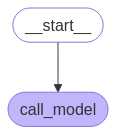

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict, List
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, state, START

class State(TypedDict):
    messages: Annotated[list, add_messages]
    foo: str


def call_model(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": response}


builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")
graph = builder.compile(checkpointer=memory)

graph
# memory에 기록 저장

체크포인터에서, 각각의 실행은 `thread`라는 이름으로 구분됩니다.   
thread_id를 활용해, 이전 출력의 정보를 저장할 수 있습니다.

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# thread_id를 통해 매 실행의 체크포인트 저장
config = {"configurable": {"thread_id": "1"}}


input_message = HumanMessage(input())

for chunk in graph.stream({"messages": [input_message]},
                          config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.
================================ Human Message =================================

나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.
================================== Ai Message ==================================

우삼겹 포케! 정말 맛있겠네요! 어떤 토핑이 들어갔어요? 맛있었다니 저도 한번 먹어보고 싶어지네요! 😊


In [ ]:
input_message = {"role": "user", "content": "어떤 소스가 가장 어울렸을까?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

어떤 소스가 가장 어울렸을까?
================================== Ai Message ==================================

우삼겹 포케에 어떤 소스가 가장 어울릴지는 정말 다양한 요소에 따라 달라질 수 있어요! 예를 들어, 어떤 종류의 야채와 곡물이 들어갔는지, 그리고 개인적인 취향에 따라서도 많이 달라지죠.

하지만 일반적으로 우삼겹의 느끼함을 잡아주면서 풍미를 더해줄 수 있는 소스들을 몇 가지 추천해 드릴게요.

*   **간장 베이스 소스:**
    *   **간장 + 참기름 + 다진 마늘 + 깨소금:** 기본적인 조합이지만 실패하기 어려운 맛이죠.
    *   **폰즈 소스:** 상큼한 맛이 우삼겹의 느끼함을 잡아줘서 깔끔하게 즐길 수 있어요.
    *   **데리야끼 소스:** 달콤 짭짤한 맛이 우삼겹과 잘 어울리고, 아이들도 좋아할 만한 맛이에요.
*   **고추장 베이스 소스:**
    *   **고추장 + 식초 + 설탕 + 다진 마늘:** 매콤하면서도 새콤달콤한 맛이 입맛을 돋우고, 우삼겹의 느끼함을 잡아줘요.
    *   **쌈장:** 한국인이라면 누구나 좋아하는 쌈장! 우삼겹과 쌈장의 조합은 말할 필요도 없죠.
*   **마요네즈 베이스 소스:**
    *   **스리라차 마요:** 매콤하면서도 부드러운 맛이 우삼겹과 잘 어울려요.
    *   **와사비 마요:** 톡 쏘는 와사비 향이 우삼겹의 느끼함을 잡아주고, 독특한 풍미를 더해줘요.

이 외에도 땅콩 소스, 참깨 소스, 유자 소스 등 다양한 소스들이 우삼겹 포케와 잘 어울릴 수 있어요.

혹시 어떤 종류의 야채나 곡물이 들어갔는지 알려주시면 좀 더 구체적인 소스를 추천해 드릴 수 있을 것 같아요! 😊


해당 체크포인트의 내용은 `thread_id`에 귀속됩니다.

In [ ]:
config = {"configurable": {"thread_id": "2"}}

input_message = {"role": "user", "content": "현미밥이었지."}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

현미밥이었지.
================================== Ai Message ==================================

네, 현미밥이었군요. 어떤 맥락에서 말씀하시는 건가요? 현미밥에 대해 궁금하신 점이 있거나, 현미밥과 관련된 이야기를 나누고 싶으신 건가요? 예를 들어:

*   **현미밥을 먹은 경험:** "현미밥이었지. 찰기가 좀 부족했지만, 씹을수록 고소했어."
*   **현미밥에 대한 생각:** "현미밥이었지. 건강에는 좋지만, 소화가 잘 안 되는 것 같아."
*   **현미밥에 대한 질문:** "현미밥이었지. 백미밥보다 칼로리가 더 높나?"

궁금하신 점이나 나누고 싶은 이야기를 알려주시면 더 자세하게 답변해 드릴 수 있습니다.


`get_state`를 통해 진행된 스레드의 마지막 상태를 볼 수 있습니다.   
해당 상태에는 State의 스냅샷 정보가 저장되어 있습니다.

In [ ]:
from rich import print as rprint
config = {"configurable": {"thread_id": "1"}}

rprint(graph.get_state(config))

StateSnapshot(
    values={
        'messages': [
            HumanMessage(
                content='나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.',
                additional_kwargs={},
                response_metadata={},
                id='feb82ba6-0540-4b77-8ed9-e37ec1e469b3'
            ),
            AIMessage(
                content='우삼겹 포케! 정말 맛있겠네요! 어떤 토핑이 들어갔어요? 맛있었다니 저도 한번 먹어보고 
싶어지네요! 😊',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'safety_ratings': []
                },
                id='run-aa21ed15-4fb0-4c88-9246-08a6976b6688-0',
                usage_metadata={
                    'input_tokens': 22,
                    'output_tokens': 46,
                    'total_tokens': 68,
                    'input_token_details': {'cache_read': 0}
                }
            ),
            HumanMessage(
                content='뭐 이것저것 많이 들어갔어. 소스가 맛있더라.',
                additional_kwargs={},
                response_metadata={},
                id='0bd731ba-4f37-4961-b14b-30e8f92683bc'
            ),
            AIMessage(
                content='소스가 맛있었다니 정말 궁금하네요! 혹시 어떤 종류의 소스였는지 기억나세요? 예를 들어, 간장
베이스인지, 고추장 베이스인지, 아니면 마요네즈 베이스인지 같은 것들이요! 😋',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'safety_ratings': []
                },
                id='run-5ad09b3d-3985-4ae2-9272-e40a8767c097-0',
                usage_metadata={
                    'input_tokens': 87,
                    'output_tokens': 71,
                    'total_tokens': 158,
                    'input_token_details': {'cache_read': 0}
                }
            ),
            HumanMessage(
                content='어떤 소스가 가장 어울렸을까?',
                additional_kwargs={},
                response_metadata={},
                id='ca759cca-a421-41b5-900a-c0c338d2d2b5'
            ),
            AIMessage(
                content='우삼겹 포케에 어떤 소스가 가장 어울릴지는 정말 다양한 요소에 따라 달라질 수 있어요! 예를 
들어, 어떤 종류의 야채와 곡물이 들어갔는지, 그리고 개인적인 취향에 따라서도 많이 달라지죠.\n\n하지만 일반적으로 
우삼겹의 느끼함을 잡아주면서 풍미를 더해줄 수 있는 소스들을 몇 가지 추천해 드릴게요.\n\n*   **간장 베이스 소스:**\n
*   **간장 + 참기름 + 다진 마늘 + 깨소금:** 기본적인 조합이지만 실패하기 어려운 맛이죠.\n    *   **폰즈 소스:** 
상큼한 맛이 우삼겹의 느끼함을 잡아줘서 깔끔하게 즐길 수 있어요.\n    *   **데리야끼 소스:** 달콤 짭짤한 맛이 
우삼겹과 잘 어울리고, 아이들도 좋아할 만한 맛이에요.\n*   **고추장 베이스 소스:**\n    *   **고추장 + 식초 + 설탕 +
다진 마늘:** 매콤하면서도 새콤달콤한 맛이 입맛을 돋우고, 우삼겹의 느끼함을 잡아줘요.\n    *   **쌈장:** 
한국인이라면 누구나 좋아하는 쌈장! 우삼겹과 쌈장의 조합은 말할 필요도 없죠.\n*   **마요네즈 베이스 소스:**\n    *  
**스리라차 마요:** 매콤하면서도 부드러운 맛이 우삼겹과 잘 어울려요.\n    *   **와사비 마요:** 톡 쏘는 와사비 향이 
우삼겹의 느끼함을 잡아주고, 독특한 풍미를 더해줘요.\n\n이 외에도 땅콩 소스, 참깨 소스, 유자 소스 등 다양한 소스들이
우삼겹 포케와 잘 어울릴 수 있어요.\n\n혹시 어떤 종류의 야채나 곡물이 들어갔는지 알려주시면 좀 더 구체적인 소스를 
추천해 드릴 수 있을 것 같아요! 😊',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'safety_ratings': []
                },
                id='run-338416f1-5ae4-4dd5-92df-39c7c614fc05-0',
                usage_metadata={
                    'input_tokens': 169,
                    'output_tokens': 531,
                    'total_tokens': 700,
                    'input_token_details': {'cache_read': 0}
                }
            )
        ]
    },
    next=(),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0065aa-0578-6ee0-8007-ebeb170e438b'
        }
    },
    metadata={
        'source': 'loop',
        'writes': {
            'call_model': {
                'messages': AIMessage(
                    content='우삼겹 포케에 어떤 소스가 가장 어울릴지는 정말 다양한 요소에 따라 달라질 수 있어요! 
예를 들어, 어떤 종류의 야채와 곡

`get_state_history()`는 전체 스냅샷 목록을 순서대로 보여줍니다.

In [ ]:
history = list(graph.get_state_history(config))
history

[StateSnapshot(values={'messages': [HumanMessage(content='나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.', additional_kwargs={}, response_metadata={}, id='feb82ba6-0540-4b77-8ed9-e37ec1e469b3'), AIMessage(content='우삼겹 포케! 정말 맛있겠네요! 어떤 토핑이 들어갔어요? 맛있었다니 저도 한번 먹어보고 싶어지네요! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-aa21ed15-4fb0-4c88-9246-08a6976b6688-0', usage_metadata={'input_tokens': 22, 'output_tokens': 46, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='뭐 이것저것 많이 들어갔어. 소스가 맛있더라.', additional_kwargs={}, response_metadata={}, id='0bd731ba-4f37-4961-b14b-30e8f92683bc'), AIMessage(content='소스가 맛있었다니 정말 궁금하네요! 혹시 어떤 종류의 소스였는지 기억나세요? 예를 들어, 간장 베이스인지, 고추장 베이스인지, 아니면 마요네즈 베이스인지 같은 것들이요! 😋', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5ad09b3

In [ ]:
for i in range(len(history)):
    print(history[i].config, len(history[i].values['messages']))
    # 메시지 개수와 config 정보

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0065aa-0578-6ee0-8007-ebeb170e438b'}} 6
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0065a9-e85c-67f0-8006-1f2f4d405ed4'}} 5
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0065a9-e851-69eb-8005-818609b38b52'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0065a9-0b45-69aa-8004-d0a863aa9b07'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0065a9-04c5-6ae3-8003-9d41c91ec711'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0065a9-04b8-69bb-8002-1d3366e51a48'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0065a6-fcee-66ae-8001-4d575cbe0a29'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0065a6-bdbb-6546-8000-2c83a95620b1'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

## Replay

위에서 얻은 Snapshot을 활용하면, 특정 시점부터 시작하는 것도 가능합니다.   

In [ ]:
history[1].values

{'messages': [HumanMessage(content='나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.', additional_kwargs={}, response_metadata={}, id='feb82ba6-0540-4b77-8ed9-e37ec1e469b3'),
  AIMessage(content='우삼겹 포케! 정말 맛있겠네요! 어떤 토핑이 들어갔어요? 맛있었다니 저도 한번 먹어보고 싶어지네요! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-aa21ed15-4fb0-4c88-9246-08a6976b6688-0', usage_metadata={'input_tokens': 22, 'output_tokens': 46, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='뭐 이것저것 많이 들어갔어. 소스가 맛있더라.', additional_kwargs={}, response_metadata={}, id='0bd731ba-4f37-4961-b14b-30e8f92683bc'),
  AIMessage(content='소스가 맛있었다니 정말 궁금하네요! 혹시 어떤 종류의 소스였는지 기억나세요? 예를 들어, 간장 베이스인지, 고추장 베이스인지, 아니면 마요네즈 베이스인지 같은 것들이요! 😋', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5ad09b3d-3985-4ae2-9272

HumanMessage의 특정 시점부터 재시작합니다.

In [ ]:
graph.invoke(None, config = history[1].config)

{'messages': [HumanMessage(content='나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.', additional_kwargs={}, response_metadata={}, id='feb82ba6-0540-4b77-8ed9-e37ec1e469b3'),
  AIMessage(content='우삼겹 포케! 정말 맛있겠네요! 어떤 토핑이 들어갔어요? 맛있었다니 저도 한번 먹어보고 싶어지네요! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-aa21ed15-4fb0-4c88-9246-08a6976b6688-0', usage_metadata={'input_tokens': 22, 'output_tokens': 46, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='뭐 이것저것 많이 들어갔어. 소스가 맛있더라.', additional_kwargs={}, response_metadata={}, id='0bd731ba-4f37-4961-b14b-30e8f92683bc'),
  AIMessage(content='소스가 맛있었다니 정말 궁금하네요! 혹시 어떤 종류의 소스였는지 기억나세요? 예를 들어, 간장 베이스인지, 고추장 베이스인지, 아니면 마요네즈 베이스인지 같은 것들이요! 😋', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5ad09b3d-3985-4ae2-9272

Replay를 수행하면, graph의 history에는 해당 실행 결과가 추가됩니다.

In [ ]:
history = list(graph.get_state_history(config))
history

[StateSnapshot(values={'messages': [HumanMessage(content='나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.', additional_kwargs={}, response_metadata={}, id='feb82ba6-0540-4b77-8ed9-e37ec1e469b3'), AIMessage(content='우삼겹 포케! 정말 맛있겠네요! 어떤 토핑이 들어갔어요? 맛있었다니 저도 한번 먹어보고 싶어지네요! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-aa21ed15-4fb0-4c88-9246-08a6976b6688-0', usage_metadata={'input_tokens': 22, 'output_tokens': 46, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='뭐 이것저것 많이 들어갔어. 소스가 맛있더라.', additional_kwargs={}, response_metadata={}, id='0bd731ba-4f37-4961-b14b-30e8f92683bc'), AIMessage(content='소스가 맛있었다니 정말 궁금하네요! 혹시 어떤 종류의 소스였는지 기억나세요? 예를 들어, 간장 베이스인지, 고추장 베이스인지, 아니면 마요네즈 베이스인지 같은 것들이요! 😋', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5ad09b3

특정 스냅샷의 값을 수정할 수도 있습니다. 이 경우, Reducer의 정의에 맞게 처리됩니다.

In [ ]:
graph.update_state(config = history[0].config, values= {'messages':'저녁 뭐 먹을까?'})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0065b8-b861-62ea-8008-542983f6c11a'}}

In [ ]:
history = list(graph.get_state_history(config))
rprint(history[0])

StateSnapshot(
    values={
        'messages': [
            HumanMessage(
                content='나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.',
                additional_kwargs={},
                response_metadata={},
                id='feb82ba6-0540-4b77-8ed9-e37ec1e469b3'
            ),
            AIMessage(
                content='우삼겹 포케! 정말 맛있겠네요! 어떤 토핑이 들어갔어요? 맛있었다니 저도 한번 먹어보고 
싶어지네요! 😊',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'safety_ratings': []
                },
                id='run-aa21ed15-4fb0-4c88-9246-08a6976b6688-0',
                usage_metadata={
                    'input_tokens': 22,
                    'output_tokens': 46,
                    'total_tokens': 68,
                    'input_token_details': {'cache_read': 0}
                }
            ),
            HumanMessage(
                content='뭐 이것저것 많이 들어갔어. 소스가 맛있더라.',
                additional_kwargs={},
                response_metadata={},
                id='0bd731ba-4f37-4961-b14b-30e8f92683bc'
            ),
            AIMessage(
                content='소스가 맛있었다니 정말 궁금하네요! 혹시 어떤 종류의 소스였는지 기억나세요? 예를 들어, 간장
베이스인지, 고추장 베이스인지, 아니면 마요네즈 베이스인지 같은 것들이요! 😋',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'safety_ratings': []
                },
                id='run-5ad09b3d-3985-4ae2-9272-e40a8767c097-0',
                usage_metadata={
                    'input_tokens': 87,
                    'output_tokens': 71,
                    'total_tokens': 158,
                    'input_token_details': {'cache_read': 0}
                }
            ),
            HumanMessage(
                content='어떤 소스가 가장 어울렸을까?',
                additional_kwargs={},
                response_metadata={},
                id='ca759cca-a421-41b5-900a-c0c338d2d2b5'
            ),
            AIMessage(
                content="우삼겹 포케에 어울리는 소스는 정말 다양해서 어떤 게 가장 '최고'라고 단정하기는 어렵지만, 
몇 가지 인기 있는 조합과 특징을 알려드릴게요. 어떤 맛을 선호하는지에 따라 선택하시면 좋을 것 같아요!\n\n**1. 간장 
베이스 소스:**\n\n*   **특징:** 짭짤하고 감칠맛이 돌아서 우삼겹의 고소한 맛과 잘 어울립니다. 참기름이나 깨를 더하면
더욱 풍미가 깊어집니다.\n*   **예시:** 간장 + 미림 + 설탕 + 다진 마늘 + 참기름 + 깨\n\n**2. 매콤한 고추장 베이스 
소스:**\n\n*   **특징:** 느끼함을 잡아주고 입맛을 돋우는 매력이 있습니다. 우삼겹의 기름진 맛과 찰떡궁합!\n*   
**예시:** 고추장 + 식초 + 설탕 + 다진 마늘 + 참기름 + 깨\n\n**3. 마요네즈 베이스 소스:**\n\n*   **특징:** 부드럽고 
고소한 맛이 강해서, 좀 더 크리미한 포케를 즐기고 싶을 때 좋습니다. 와사비나 스리라차 소스를 살짝 더하면 느끼함을 
줄일 수 있습니다.\n*   **예시:** 마요네즈 + 레몬즙 + 꿀 (또는 설탕) + 소금 + 후추\n\n**4. 스리라차 마요 
소스:**\n\n*   **특징:** 마요네즈의 고소함과 스리라차의 매콤함이 조화롭게 어우러져, 느끼함 없이 깔끔하게 즐길 수 
있습니다.\n*   **예시:** 마요네즈 + 스리라차 소스 + 레몬즙\n\n**5. 참깨 드레싱:**\n\n*   **특징:** 고소하고 담백한 
맛으로, 다른 재료들의 맛을 해치지 않으면서 은은하게 풍미를 더해줍니다.\n*   **예시:** 시판 참깨 드레싱 또는 직접 
만들기 (참깨 + 간장 + 식초 + 설탕 + 참기름)\n\n**팁:**\n\n*   **토핑에 따라:** 아보카도나 해초류가 많이 들어갔다면 
간장이나 참깨 드레싱이, 신선한 채소가 많다면 매콤한 고추장 베이스 소스가 잘 어울릴 수 있습니다.\n*   **개인 취향:**
결국 가장 중요한 건 본인의 입맛입니다! 위에 제시된 소스들을 참고해서, 자신만의 최적의 조합을 찾아보세요.\n\n혹시 
드셨던 포케에 어떤 토핑이 들어갔었는지 알려주시면, 더 잘 어울리는 소스를 추천해 드릴 수 있어요! 😊",
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'safety_ratings': []
                },
                id='run-e3579026-09ae-43e6-a9b3-a57e59ddb389-0',
                usage_metadata={
                    'input_tokens': 169,
                    'output_tokens': 688,
                    'total_tokens': 857,
                    'input_token_details': {'cache_read': 0}
                }
            ),
            HumanMessage(
                content='저녁 뭐 먹을까?',
                additional_kwargs={},
                response_metadata={},
                id='ed

In [ ]:
graph.invoke(None, config = history[0].config)

{'messages': [HumanMessage(content='나는 오늘 점심에 우삼겹 포케를 먹었는데, 맛있었어.', additional_kwargs={}, response_metadata={}, id='feb82ba6-0540-4b77-8ed9-e37ec1e469b3'),
  AIMessage(content='우삼겹 포케! 정말 맛있겠네요! 어떤 토핑이 들어갔어요? 맛있었다니 저도 한번 먹어보고 싶어지네요! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-aa21ed15-4fb0-4c88-9246-08a6976b6688-0', usage_metadata={'input_tokens': 22, 'output_tokens': 46, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='뭐 이것저것 많이 들어갔어. 소스가 맛있더라.', additional_kwargs={}, response_metadata={}, id='0bd731ba-4f37-4961-b14b-30e8f92683bc'),
  AIMessage(content='소스가 맛있었다니 정말 궁금하네요! 혹시 어떤 종류의 소스였는지 기억나세요? 예를 들어, 간장 베이스인지, 고추장 베이스인지, 아니면 마요네즈 베이스인지 같은 것들이요! 😋', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5ad09b3d-3985-4ae2-9272

## SQLite를 이용한 Checkpointing

`SqliteSaver`를 사용해, 체크포인팅을 저장할 수 있습니다.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
checkpointer = SqliteSaver(conn)

graph = builder.compile(checkpointer=checkpointer)


In [ ]:
config = {"configurable": {"thread_id": "1"}}


input_message = HumanMessage(input())

for chunk in graph.stream({"messages": [input_message]},
                          config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

오늘 점심으로는 타코를 먹었어! 화요일이었거든.
================================ Human Message =================================

오늘 점심으로는 타코를 먹었어! 화요일이었거든.
================================== Ai Message ==================================

오, 타코 화요일을 즐기셨군요! 어떤 타코를 드셨어요? 맛있었겠네요! 🌮😋


In [ ]:
input_message = {"role": "user", "content": "너는 뭐가 좋겠니?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

너는 뭐가 좋겠니?
================================== Ai Message ==================================

제가 먹을 수 있다면, 저는 신선한 재료로 만든 맛있는 비빔밥이 먹고 싶어요! 다양한 채소와 고기, 그리고 고소한 참기름 향이 정말 좋을 것 같아요. 😋 하지만 저는 먹을 수 없으니, 당신이 좋아하는 음식을 드시는 게 가장 좋겠죠? 😉


## Store를 이용한 장기 메모리 추가하기   

Thread Checkpoint는 단일 세션의 메모리를 저장하기에는 효과적이지만,   
세션이 유지되지 않는 경우에는 다른 방법이 필요합니다.   

InMemoryStore를 통해, 장기 메모리를 추가할 수 있습니다.


In [ ]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

Namespace를 통해 메모리 위치를 설정합니다.

In [ ]:
namespace_for_memory = ('1', 'memories')

In [ ]:
import uuid
memory_id = str(uuid.uuid4())

memory = {'information' : "GPT 4.5가 엄청 비싸요."}
in_memory_store.put(namespace_for_memory, memory_id, memory)
memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='b5de014e-c0b5-4db0-b35d-de5a42866e44', value={'information': '지금은 랭그래프 메모리 실습 중입니다.'}, created_at='2025-03-21T13:55:54.263667+00:00', updated_at='2025-03-21T13:55:54.263670+00:00', score=None),
 Item(namespace=['1', 'memories'], key='e28b4187-42db-4d89-8025-65f32e07feb7', value={'information': 'GPT 4.5가 엄청 비싸요.'}, created_at='2025-03-21T13:56:15.410960+00:00', updated_at='2025-03-21T13:56:15.410981+00:00', score=None)]

In [ ]:
memory = {'name' : "FastCampus"}
memory_id = str(uuid.uuid4())

in_memory_store.put(namespace_for_memory, memory_id, memory)
# memory_id에 매핑되는 구조

memories = in_memory_store.search(namespace_for_memory)
memories


[Item(namespace=['1', 'memories'], key='b5de014e-c0b5-4db0-b35d-de5a42866e44', value={'information': '지금은 랭그래프 메모리 실습 중입니다.'}, created_at='2025-03-21T13:55:54.263667+00:00', updated_at='2025-03-21T13:55:54.263670+00:00', score=None),
 Item(namespace=['1', 'memories'], key='e28b4187-42db-4d89-8025-65f32e07feb7', value={'information': 'GPT 4.5가 엄청 비싸요.'}, created_at='2025-03-21T13:56:15.410960+00:00', updated_at='2025-03-21T13:56:15.410981+00:00', score=None),
 Item(namespace=['1', 'memories'], key='1eeaaa4a-b54f-4e18-8ffd-f48dfb429de5', value={'name': 'FastCampus'}, created_at='2025-03-21T13:56:45.283100+00:00', updated_at='2025-03-21T13:56:45.283104+00:00', score=None)]

In [ ]:
# 메모리 레코드 추가하기
memory_id = str(uuid.uuid4())
new_memory  = {'name' : "LangGraph"}

in_memory_store.put(namespace_for_memory, memory_id, new_memory)
# memory_id에 매핑되는 구조

memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='b5de014e-c0b5-4db0-b35d-de5a42866e44', value={'information': '지금은 랭그래프 메모리 실습 중입니다.'}, created_at='2025-03-21T13:55:54.263667+00:00', updated_at='2025-03-21T13:55:54.263670+00:00', score=None),
 Item(namespace=['1', 'memories'], key='e28b4187-42db-4d89-8025-65f32e07feb7', value={'information': 'GPT 4.5가 엄청 비싸요.'}, created_at='2025-03-21T13:56:15.410960+00:00', updated_at='2025-03-21T13:56:15.410981+00:00', score=None),
 Item(namespace=['1', 'memories'], key='1eeaaa4a-b54f-4e18-8ffd-f48dfb429de5', value={'name': 'FastCampus'}, created_at='2025-03-21T13:56:45.283100+00:00', updated_at='2025-03-21T13:56:45.283104+00:00', score=None),
 Item(namespace=['1', 'memories'], key='6a4f754b-c475-467d-856c-86854e3099a7', value={'name': 'LangGraph'}, created_at='2025-03-21T13:57:05.356274+00:00', updated_at='2025-03-21T13:57:05.356276+00:00', score=None)]

In [ ]:
# 메모리 덮어씌우기
new_memory  = {'name' : "패스트캠퍼스"}

in_memory_store.put(namespace_for_memory, memory_id, new_memory)
# memory_id에 매핑되는 구조

memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='b5de014e-c0b5-4db0-b35d-de5a42866e44', value={'information': '지금은 랭그래프 메모리 실습 중입니다.'}, created_at='2025-03-21T13:55:54.263667+00:00', updated_at='2025-03-21T13:55:54.263670+00:00', score=None),
 Item(namespace=['1', 'memories'], key='e28b4187-42db-4d89-8025-65f32e07feb7', value={'information': 'GPT 4.5가 엄청 비싸요.'}, created_at='2025-03-21T13:56:15.410960+00:00', updated_at='2025-03-21T13:56:15.410981+00:00', score=None),
 Item(namespace=['1', 'memories'], key='1eeaaa4a-b54f-4e18-8ffd-f48dfb429de5', value={'name': 'FastCampus'}, created_at='2025-03-21T13:56:45.283100+00:00', updated_at='2025-03-21T13:56:45.283104+00:00', score=None),
 Item(namespace=['1', 'memories'], key='6a4f754b-c475-467d-856c-86854e3099a7', value={'name': '패스트캠퍼스'}, created_at='2025-03-21T13:57:21.109558+00:00', updated_at='2025-03-21T13:57:21.109561+00:00', score=None)]

In [ ]:
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': '6a4f754b-c475-467d-856c-86854e3099a7',
 'value': {'name': '패스트캠퍼스'},
 'created_at': '2025-03-21T13:57:21.109558+00:00',
 'updated_at': '2025-03-21T13:57:21.109561+00:00',
 'score': None}

## memory 검색    
메모리에 임베딩 모델을 설정하면 임베딩 기반의 인덱싱/검색이 가능합니다.    
주로 사용할 수 있는 다국어 임베딩은 다음과 같습니다.   
1. 온라인/ OpenAI의 `text-embedding-3-small`, `text-embedding-3-large` (유료)
2. 온라인/ Google `gemini-embedding-exp-03-07` (유료, 무료 제한 1일 100개)
3. 오프라인/ HuggingFace에서 지원하는 `bge-m3`, `multilingual-e5`, `KURE-v1`    

이번 실습에서는 가장 작은 임베딩 모델 중 하나인 `text-embedding-3-small`를 사용합니다.   

**실제 임베딩 모델을 선정하실 때는 GPU 자원에 따라 MTEB 리더보드 (https://huggingface.co/spaces/mteb/leaderboard) 에서 한국어 성능 순위를 참고하시는 것을 추천합니다!**

In [ ]:
!pip install langchain-huggingface sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

HuggingFace에서 임베딩을 다운로드하여 로컬 폴더에 저장합니다.

In [ ]:
from sentence_transformers import SentenceTransformer

# HuggingFace 임베딩 주소 지정하기
# nlpai-lab/KURE-v1 , baai/bge-m3, 등의 주소를 입력하여 지정

model_name = 'intfloat/multilingual-e5-small'

# CPU 설정으로 모델 불러오기
# device='cuda'로 변경하면 GPU에서 로드
emb_model = SentenceTransformer(model_name, device='cpu')

# 로컬 폴더에 모델 저장하기
emb_model.save('./embedding')
del emb_model

import gc
gc.collect()
# 메모리 정리하기

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

401

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

# 허깅페이스 포맷의 임베딩 모델 불러오기
embeddings = HuggingFaceEmbeddings(model_name= './embedding',
                                   model_kwargs={'device':'cuda'})
# GPU가 있는 경우, CUDA(GPU) 설정

In [ ]:
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1024, # 임베딩 차원(모델마다 다름)
        "fields": ["comments"] # 임베딩을 활용해 저장할 필드 지정
    }
)

In [ ]:
memory_id

'6a4f754b-c475-467d-856c-86854e3099a7'

In [ ]:
namespace_for_memory = ('1', 'information')
memory_id = str(uuid.uuid4())

store.put(namespace_for_memory,
          memory_id,
          {'ID':'JohnDoe1', 'comments':'안녕하세요! 저는 John Doe이고, 23살입니다.'})

store.search(namespace_for_memory, limit=20)

[Item(namespace=['1', 'information'], key='5afbad6d-2b8e-457d-9625-171cadb704b2', value={'ID': 'JohnDoe1', 'comments': '안녕하세요! 저는 John Doe이고, 23살입니다.'}, created_at='2025-03-21T14:08:26.855756+00:00', updated_at='2025-03-21T14:08:26.855761+00:00', score=None)]

In [ ]:
def add_records(store, namespace, data_records):
    for data in data_records:
        store.put(namespace, str(uuid.uuid4()), data)

example_data = [
    {'Hello':'world'},
    {'ID':'Admin', 'comments':'이 계정은 운영 전용 계정입니다.'},
    {'ID':'GPT_Agent1', 'comments':'GPT-4o Agent 전용 계정'},
    {'ID':'Gemini_Agent1', 'comments':'Gemini-2.0-flash Agent 전용 계정'}
]

add_records(store,namespace_for_memory, example_data)


history = store.search(namespace_for_memory)
history

[Item(namespace=['1', 'information'], key='5afbad6d-2b8e-457d-9625-171cadb704b2', value={'ID': 'JohnDoe1', 'comments': '안녕하세요! 저는 John Doe이고, 23살입니다.'}, created_at='2025-03-21T14:08:26.855756+00:00', updated_at='2025-03-21T14:08:26.855761+00:00', score=None),
 Item(namespace=['1', 'information'], key='f45f8af5-2288-4c83-914f-991b55faf7a9', value={'Hello': 'world'}, created_at='2025-03-21T14:09:15.028010+00:00', updated_at='2025-03-21T14:09:15.028015+00:00', score=None),
 Item(namespace=['1', 'information'], key='6ce6cd7d-5f5b-4628-85fc-6ac20cde2c0a', value={'ID': 'Admin', 'comments': '이 계정은 운영 전용 계정입니다.'}, created_at='2025-03-21T14:09:15.048869+00:00', updated_at='2025-03-21T14:09:15.048873+00:00', score=None),
 Item(namespace=['1', 'information'], key='2fa179c7-924d-47a0-8fb2-ad5525e1a5e1', value={'ID': 'GPT_Agent1', 'comments': 'GPT-4o Agent 전용 계정'}, created_at='2025-03-21T14:09:15.065154+00:00', updated_at='2025-03-21T14:09:15.065156+00:00', score=None),
 Item(namespace=['1', 'infor

In [ ]:
print('\n'.join(['['+str(i.created_at)[0:10] + '] ' + i.value['comments'] if 'comments' in i.value else '' for i in history]))

[2025-03-21] 안녕하세요! 저는 John Doe이고, 23살입니다.

[2025-03-21] 이 계정은 운영 전용 계정입니다.
[2025-03-21] GPT-4o Agent 전용 계정
[2025-03-21] Gemini-2.0-flash Agent 전용 계정


In [ ]:
result = store.search(
    namespace_for_memory,
    query = 'Gemini Agent 버전은 뭔가요?',
    limit = 2
)
result

[Item(namespace=['1', 'information'], key='48dd88d1-5aed-4004-a298-ae021cdf8816', value={'ID': 'Gemini_Agent1', 'comments': 'Gemini-2.0-flash Agent 전용 계정'}, created_at='2025-03-21T14:09:15.080112+00:00', updated_at='2025-03-21T14:09:15.080115+00:00', score=0.894333969781483),
 Item(namespace=['1', 'information'], key='2fa179c7-924d-47a0-8fb2-ad5525e1a5e1', value={'ID': 'GPT_Agent1', 'comments': 'GPT-4o Agent 전용 계정'}, created_at='2025-03-21T14:09:15.065154+00:00', updated_at='2025-03-21T14:09:15.065156+00:00', score=0.8406650756732776)]

In [ ]:
type(result[0])

langgraph.store.base.SearchItem

이렇게 생성된 store는 각 Node에 State와 함께 포함할 수 있습니다.  
실제 채팅 시나리오를 통해 구현해 보겠습니다.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver


memory = MemorySaver()
in_memory_store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1024, # 임베딩 차원(모델마다 다름)
        "fields": ["memory"] # 임베딩을 활용해 저장할 필드 지정
    }
)

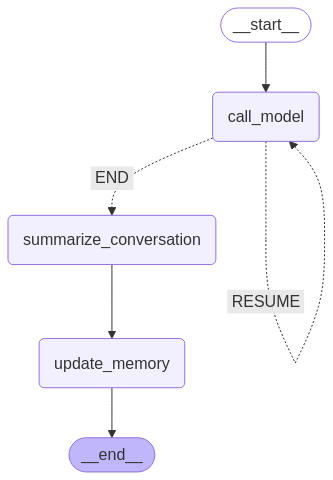

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict, List
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, state, START, END
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig


class State(TypedDict):
    messages: Annotated[list, add_messages]
    summary: str



def call_model(state: State, config: RunnableConfig, store: BaseStore):

    user_id = config['configurable']['user_id']
    namespace = (user_id, "information")

    def gen_memories(history):
        return '\n'.join(['['+str(i.created_at)[0:10] + '] ' + i.value['memory'] if 'memory' in i.value else '' for i in history])

    summary = gen_memories(store.search(namespace))

    prompt = [SystemMessage(content=f"""
당신은 고객 상담 챗봇입니다.
고객은 이전에 아래의 상담을 한 적이 있습니다. 과거 내역을 참고하여 응답하세요.
첫 대화는 친절한 인사로 시작하세요.
---
Previous Conversation Summary: {summary}"""), HumanMessage(content="안녕하세요!")] + state['messages']

     # 과거 정보를 상위 Context에 포함하기
    response = llm.invoke(prompt)
    print('Assistant:', response.content)

    user_message = HumanMessage(content = input())


    return {"messages": [response, user_message]}

def summarize_conversation(state: State, config: RunnableConfig, store: BaseStore):

    summary_prompt = """현재까지의 대화 내용을 요약하여 데이터베이스에 저장하려고 합니다.
이전의 Summary 내용과 이어지는 경우, 해당 내용을 포함하여 요약하세요.
만약 새로운 주제인 경우, 새로운 대화 내용만 요약하세요.
대화 내용을 3~5문장 길이로 요약하세요. 요약 이외의 다른 내용은 출력하지 마세요.
또한, 요약을 요청했다는 사실도 작성하지 마세요.
"""
    prompt = state['messages'][:-1] + [HumanMessage(content = summary_prompt)]
    # END 제외

    response = llm.invoke(prompt)

    delete_messages = [RemoveMessage(id=m.id) for m in state['messages']]
    return {'summary': response.content, 'messages':delete_messages}



def update_memory(state:State, config: RunnableConfig, store:BaseStore):

    user_id = config['configurable']['user_id']
    namespace = (user_id, "information")

    memory_id = str(uuid.uuid4())


    memory = state["summary"]

    store.put(namespace, memory_id, {'memory':memory})

def check_end(state:State):
    last_msg = state["messages"][-1]

    if last_msg.content.upper()=='END':
        return 'END'
    return 'RESUME'

builder = StateGraph(State)


builder.add_node('update_memory', update_memory)
builder.add_node("call_model", call_model)
builder.add_node('summarize_conversation', summarize_conversation)

builder.add_edge(START, "call_model")
builder.add_conditional_edges('call_model',
                              check_end,
                              {'END':'summarize_conversation',
                               'RESUME':'call_model'})
builder.add_edge('summarize_conversation','update_memory')
builder.add_edge('update_memory', END)

graph = builder.compile(checkpointer=memory, store=in_memory_store)

graph
# memory에 기록 저장

In [ ]:
print('END를 입력하면 대화가 종료됩니다.')

config = {'configurable':{'thread_id':'2', 'user_id':'admin'}}
for data in graph.stream(
    {'messages':[]},
    config,stream_mode="updates"):
    print(data)

END를 입력하면 대화가 종료됩니다.
Assistant: 안녕하세요! 무엇을 도와드릴까요?
안녕? 나는 오늘 젬마 3를 써봤는데, 한국어 성능이 뛰어나대!
{'call_model': {'messages': [AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a2ff7b04-5fc6-4026-9b35-37c964aaa097-0', usage_metadata={'input_tokens': 69, 'output_tokens': 15, 'total_tokens': 84, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='안녕? 나는 오늘 젬마 3를 써봤는데, 한국어 성능이 뛰어나대!', additional_kwargs={}, response_metadata={}, id='c20760e2-8ccb-4487-8799-64e4a2ea6118')]}}
Assistant: 안녕하세요! 젬마 3를 사용해 보셨군요! 한국어 성능이 뛰어나다는 점을 알고 계시는군요. 혹시 사용하시면서 궁금한 점이나 불편한 점이 있으셨나요? 아니면 젬마 3에 대해 더 자세히 알고 싶으신 점이 있으신가요? 편하게 말씀해주세요!
한국어 성능이 왜 좋은거야?
{'call_model': {'messages': [AIMessage(content='안녕하세요! 젬마 3를 사용해 보셨군요! 한국어 성능이 뛰어나다는 점을 알고 계시는군요. 혹시 사용하시면서 궁금한 점이나 불편한 점이 있으셨나요? 아니면 젬마 3에 대해 더 자세히 알고 싶으신 점이 있으신가요? 편하게 말씀해주세요!', additional_kwargs={}, response_metad

In [ ]:
config = {'configurable':{'thread_id':'8', 'user_id':'admin'}}
graph.invoke({'messages':[]}, config)

Assistant: 안녕하세요! 이전 젬마 3 관련 문의에 이어 다시 찾아주셔서 감사합니다. 무엇을 도와드릴까요? 😊
오늘은 아침 브런치 메뉴를 추천받고 싶은데.
Assistant: 아침 브런치 메뉴 추천을 원하시는군요! 어떤 스타일의 브런치를 선호하시나요? 예를 들어, 다음과 같은 질문에 답해주시면 더 정확한 추천이 가능합니다.

*   **어떤 종류의 음식을 좋아하시나요?** (예: 달콤한 것, 짭짤한 것, 건강한 것 등)
*   **만드는 데 얼마나 시간을 투자할 수 있나요?** (예: 간단한 메뉴, 정성 들인 메뉴)
*   **어떤 재료가 집에 있나요?** (예: 계란, 빵, 과일 등)

이러한 정보를 바탕으로 맛있는 브런치 메뉴를 추천해 드릴게요!
건강한 것으로 부탁해.
Assistant: 건강한 브런치를 원하시는군요! 그렇다면 다음과 같은 메뉴들을 추천해 드립니다:

1.  **아보카도 토스트:** 통밀빵에 으깬 아보카도를 올리고 소금, 후추, 약간의 레몬즙으로 간을 합니다. 취향에 따라 계란 프라이나 토마토를 추가해도 좋습니다. 아보카도의 건강한 지방과 통밀빵의 식이섬유가 포만감을 줍니다.
2.  **그릭 요거트 볼:** 그릭 요거트에 신선한 과일(베리류, 바나나 등)과 견과류, 씨앗류(치아씨드, 아마씨 등)를 얹어 먹습니다. 꿀이나 메이플 시럽을 약간 추가해도 좋습니다. 단백질과 비타민, 미네랄이 풍부한 건강한 메뉴입니다.
3.  **오트밀:** 오트밀을 우유나 물에 끓여 부드럽게 만든 후, 과일, 견과류, 씨앗류를 얹어 먹습니다. 시나몬 가루를 약간 뿌려도 좋습니다. 식이섬유가 풍부하여 장 건강에 좋습니다.
4.  **스무디:** 과일(베리류, 바나나, 망고 등), 채소(시금치, 케일 등), 요거트 또는 우유를 함께 갈아 만든 스무디입니다. 단백질 파우더나 견과류 버터를 추가하여 영양을 더할 수도 있습니다.

이 중에서 어떤 메뉴가 가장 마음에 드시나요? 아니면, 특별히 피하고 싶은 재료가 있으신가요?
END


{'messages': [],
 'summary': '사용자는 아침 브런치 메뉴 추천을 요청했습니다. 건강한 메뉴를 선호한다고 밝혔으며, 이에 따라 아보카도 토스트, 그릭 요거트 볼, 오트밀, 스무디 등의 메뉴가 추천되었습니다. 사용자는 이전에 젬마 3 관련 문의를 한 적이 있습니다.'}

In [ ]:
graph.get_state(config=config)

StateSnapshot(values={'messages': [], 'summary': '사용자는 아침 브런치 메뉴 추천을 요청했습니다. 건강한 메뉴를 선호한다고 밝혔으며, 이에 따라 아보카도 토스트, 그릭 요거트 볼, 오트밀, 스무디 등의 메뉴가 추천되었습니다. 사용자는 이전에 젬마 3 관련 문의를 한 적이 있습니다.'}, next=(), config={'configurable': {'thread_id': '8', 'checkpoint_ns': '', 'checkpoint_id': '1f006615-edba-60d8-8005-926bca78d521'}}, metadata={'source': 'loop', 'writes': {'update_memory': None}, 'thread_id': '8', 'user_id': 'admin', 'step': 5, 'parents': {}}, created_at='2025-03-21T14:32:52.153141+00:00', parent_config={'configurable': {'thread_id': '8', 'checkpoint_ns': '', 'checkpoint_id': '1f006615-ed91-69b0-8004-11ce34c1218d'}}, tasks=())

In [ ]:
in_memory_store.list_namespaces()

[('admin', 'information')]

In [ ]:
in_memory_store.search(('admin', 'information'), query='랭그래프', limit=3)

[Item(namespace=['admin', 'information'], key='08bd0862-71c9-480b-8f65-2f99685c2433', value={'memory': '사용자는 랭체인 생태계의 랭그래프에 대한 지식을 확인하고, 랭그래프의 기본 개념, 활용 분야, 랭체인과의 관계 등에 대한 질문이 가능하다는 답변을 받았습니다. 이후 사용자는 대화 내용을 요약하여 데이터베이스에 저장하고, 이전 요약 내용이 있을 경우 이를 포함하여 요약하며, 새로운 주제일 경우 새로운 대화 내용만 요약하는 것을 요청했습니다. 요약은 3~5문장 길이로 제공되며, 요약 요청 사실은 기록되지 않습니다.'}, created_at='2025-03-21T14:34:18.606655+00:00', updated_at='2025-03-21T14:34:18.606658+00:00', score=0.8380613444294231),
 Item(namespace=['admin', 'information'], key='34a2f154-27fc-4799-bbf0-88f51fdc022a', value={'memory': '사용자는 아침 브런치 메뉴 추천을 요청했습니다. 건강한 메뉴를 선호한다고 밝혔으며, 이에 따라 아보카도 토스트, 그릭 요거트 볼, 오트밀, 스무디 등의 메뉴가 추천되었습니다. 사용자는 이전에 젬마 3 관련 문의를 한 적이 있습니다.'}, created_at='2025-03-21T14:32:52.152007+00:00', updated_at='2025-03-21T14:32:52.152010+00:00', score=0.7792949231583357),
 Item(namespace=['admin', 'information'], key='4e9292e5-4b1b-4e6b-abd1-af9bab890362', value={'memory': '- 사용자가 젬마 3를 사용해 보았으며, 한국어 성능이 뛰어나다는 것을 알고 있다고 언급했습니다.\n- 젬마 3의 한국어 성능이 좋은 이유에

In [ ]:
# 다른 thread id로 해도 이전 정보를 참고함
config = {'configurable':{'thread_id':'9', 'user_id':'admin'}}
for data in graph.stream(
    {'messages':[]},
    config,stream_mode="updates"):
    print(data)

Assistant: 안녕하세요! 오늘 하루도 활기차게 시작하시길 바랍니다. 무엇을 도와드릴까요? 지난 번 젬마 3에 대한 문의와 아침 브런치 메뉴 추천에 이어, 또 궁금한 점이 있으시거나 필요한 정보가 있으시면 언제든지 말씀해주세요. 😊
너 랭그래프 좀 알아?
{'call_model': {'messages': [AIMessage(content='안녕하세요! 오늘 하루도 활기차게 시작하시길 바랍니다. 무엇을 도와드릴까요? 지난 번 젬마 3에 대한 문의와 아침 브런치 메뉴 추천에 이어, 또 궁금한 점이 있으시거나 필요한 정보가 있으시면 언제든지 말씀해주세요. 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8c730e73-eb24-4cac-a6e9-fccf986c8c20-0', usage_metadata={'input_tokens': 293, 'output_tokens': 88, 'total_tokens': 381, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='너 랭그래프 좀 알아?', additional_kwargs={}, response_metadata={}, id='b3fd3577-6ad8-441b-bf27-0358f766c5b5')]}}
Assistant: 랭그래프(LangGraph)에 대해 알고 있습니다. 랭체인(LangChain) 생태계의 일부로, LLM(Large Language Model)을 사용하여 구축된 복잡한 멀티 에이전트 워크플로우를 오케스트레이션하고 관리하는 데 사용되는 도구입니다.

랭그래프에 대해 어떤 점이 궁금하신가요? 예를 들어 다음과 같은 질문에 답변해 드릴 수 있습니다.

*   랭그래프의 기본적인 개념과 작동 방식
*

# SQLite Store 사용하기

외부 DB를 연동하는 기능은 현재 직접 지원하지 않으며, BaseStore Class를 이용해 구현해야 합니다.   
PostGresStore를 사용하는 경우: https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.postgres.PostgresStore

In [ ]:
from langgraph.store.base import BaseStore, SearchItem
from typing import List, Optional, Dict, Any, Tuple
import sqlite3
import json
from datetime import datetime
import uuid
import numpy as np
from sentence_transformers import SentenceTransformer

class SQLiteStore(BaseStore):
    def __init__(self, db_path: str = "store.db", embedding_model: str = 'intfloat/multilingual-e5-large'):
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path, check_same_thread=False)
        self.embedding_model = embedding_model
        self._setup()

    def _setup(self):
        """데이터베이스 테이블 생성"""
        cursor = self.conn.cursor()

        # 메인 스토어 테이블
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS store (
                namespace TEXT,
                key TEXT,
                value TEXT,
                created_at TEXT,
                updated_at TEXT,
                PRIMARY KEY (namespace, key)
            )
        """)

        # 임베딩 테이블
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS embeddings (
                namespace TEXT,
                key TEXT,
                embedding BLOB,
                text TEXT,
                PRIMARY KEY (namespace, key),
                FOREIGN KEY (namespace, key) REFERENCES store(namespace, key)
            )
        """)

        self.conn.commit()

    def _get_embedding(self, text: str) -> np.ndarray:
        """텍스트의 임베딩 벡터 생성"""
        model = SentenceTransformer(self.embedding_model)
        return model.encode(text)

    def _cosine_similarity(self, a: np.ndarray, b: np.ndarray) -> float:
        """코사인 유사도 계산"""
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


    def batch(self, operations: List[Tuple[str, Tuple[str, ...], str, Dict[str, Any]]]) -> None:
        """일괄 작업 처리"""
        for op, namespace, key, value in operations:
            if op == "put":
                self.put(namespace, key, value)
            elif op == "delete":
                self.delete(namespace, key)
    async def abatch(self, operations: List[Tuple[str, Tuple[str, ...], str, Dict[str, Any]]]) -> None:
        """비동기 일괄 작업 처리"""
        self.batch(operations)  # SQLite는 기본적으로 동기식이므로 동기 메서드를 호출




    def put(self, namespace: Tuple[str, ...], key: str, value: Dict[str, Any], index: bool = True) -> None:
        """데이터 저장"""
        namespace_str = json.dumps(namespace)
        value_str = json.dumps(value)
        now = datetime.utcnow().isoformat()

        cursor = self.conn.cursor()
        cursor.execute("""
            INSERT OR REPLACE INTO store (namespace, key, value, created_at, updated_at)
            VALUES (?, ?, ?, ?, ?)
        """, (namespace_str, key, value_str, now, now))

        # 임베딩 저장
        if index:
            # value에서 텍스트 추출 (예: 'memory' 필드)
            text_to_embed = value.get('memory', '') if isinstance(value, dict) else str(value)
            if text_to_embed:
                embedding = self._get_embedding(text_to_embed)
                cursor.execute("""
                    INSERT OR REPLACE INTO embeddings (namespace, key, embedding, text)
                    VALUES (?, ?, ?, ?)
                """, (namespace_str, key, embedding.tobytes(), text_to_embed))

        self.conn.commit()

    def get(self, namespace: Tuple[str, ...], key: str) -> Optional[Dict[str, Any]]:
        """데이터 조회"""
        namespace_str = json.dumps(namespace)
        cursor = self.conn.cursor()
        cursor.execute("""
            SELECT value FROM store WHERE namespace = ? AND key = ?
        """, (namespace_str, key))
        result = cursor.fetchone()

        if result:
            return json.loads(result[0])
        return None

    def search(self, namespace: Tuple[str, ...], query: Optional[str] = None, limit: int = 20) -> List[SearchItem]:
        """데이터 검색 (임베딩 기반 또는 텍스트 기반)"""
        namespace_str = json.dumps(namespace)
        cursor = self.conn.cursor()

        if query:
            # 임베딩 기반 검색
            query_embedding = self._get_embedding(query)

            # 모든 임베딩 가져오기
            cursor.execute("""
                SELECT e.embedding, e.text, s.key, s.value, s.created_at, s.updated_at
                FROM embeddings e
                JOIN store s ON e.namespace = s.namespace AND e.key = s.key
                WHERE e.namespace = ?
            """, (namespace_str,))

            results = []
            for row in cursor.fetchall():
                embedding = np.frombuffer(row[0], dtype=np.float32)
                similarity = self._cosine_similarity(query_embedding, embedding)
                results.append(SearchItem(
                key=row[2],          # key는 세 번째 컬럼
                value=json.loads(row[3]),  # value는 네 번째 컬럼
                created_at=datetime.fromisoformat(row[4]),  # created_at은 다섯 번째 컬럼
                updated_at=datetime.fromisoformat(row[5]),  # updated_at은 여섯 번째 컬럼
                namespace=namespace,
                score = similarity
            ))

            # 유사도 기준으로 정렬
            results.sort(key=lambda x: x.score, reverse=True)
            return results[:limit]
        else:
            # 일반 텍스트 검색
            cursor.execute("""
                SELECT key, value, created_at, updated_at
                FROM store
                WHERE namespace = ?
                ORDER BY created_at DESC LIMIT ?
            """, (namespace_str, limit))

            results = []
            for row in cursor.fetchall():
                value = json.loads(row[1])
                results.append(SearchItem(
                key=row[0],
                value=value,
                created_at=datetime.fromisoformat(row[2]),
                updated_at=datetime.fromisoformat(row[3]),
                namespace=namespace  # 원래 search 메서드에 전달된 namespace 사용
                ))

            return results

    def delete(self, namespace: Tuple[str, ...], key: str) -> None:
        """데이터 삭제"""
        namespace_str = json.dumps(namespace)
        cursor = self.conn.cursor()

        # 임베딩도 함께 삭제
        cursor.execute("""
            DELETE FROM embeddings WHERE namespace = ? AND key = ?
        """, (namespace_str, key))

        cursor.execute("""
            DELETE FROM store WHERE namespace = ? AND key = ?
        """, (namespace_str, key))

        self.conn.commit()

    def list_namespaces(self) -> List[Tuple[str, ...]]:
        """네임스페이스 목록 조회"""
        cursor = self.conn.cursor()
        cursor.execute("SELECT DISTINCT namespace FROM store")
        return [tuple(json.loads(row[0])) for row in cursor.fetchall()]

In [ ]:
graph

In [ ]:
# SQLite 스토어 인스턴스 생성
sqlite_store = SQLiteStore(db_path = 'example.db', embedding_model = model_name)

graph = builder.compile(checkpointer=memory, store=sqlite_store)

print('END를 입력하면 대화가 종료됩니다.')

config = {'configurable':{'thread_id':'1', 'user_id':'admin'}}
for data in graph.stream(
    {'messages':[]},
    config,stream_mode="updates"):
    print(data)

In [ ]:
sqlite_store.list_namespaces()

In [ ]:
memories = sqlite_store.search(('admin', 'information'))
for result in memories:
    print(result)

In [ ]:
# 임베딩 검색 사용 예시
# memory에서 값을 검색하도록 설정(SQLite Store Class 참고)

results = sqlite_store.search(('admin', 'information'), query="코딩", limit=1)
for result in results:
    print(result)


Langsmith (https://smith.langchain.com )에서 실행 결과를 확인할 수 있습니다.